<h1>Obtención de distancias en una escena usando dos perspectivas</h1>

<p>En este Mini proyecto vamos a calcular una distancia en una escena usando el concepto de disparidad que se vio en clase. </p>

In [1]:
#Importación de librerias que necesitaremos
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

<h2>1.- Calibración de las camaras </h2>

La primera parte consiste en realizar la calibración estereo de dos cámaras, aquí dado que carezco con muchos dispositivos con cámara decidí usar el mismo (un ipad) para ir tomando fotos del patrón de ajedrez desde dos posiciones distintas. Fue necesario aquí asegurar dentro de lo posible que las perspectivas para las camaras fuesen las mismas.  

In [2]:


class CameraCalibrator:
    
    
    checkerboardImagesLeft = None
    checkerboardImagesRight = None
    checkerSize = None
    patternWidth = None
    patternHeight = None
    leftImagesCorners = None
    rightImagesCorners = None
    objPoints = None
    imagesWithCornersLeft = None
    imagesWithCornersRight = None
    points3d = None
    #Calibración 
    cameraMatrixLeft = None
    cameraMatrixRight = None
    translation = None
    rotation = None
    essentialMatrix = None
    fundamentalMatrix = None
    distortCoeffsLeft = None
    distortCoeffsRight = None
    
    
    def __init__(self, pathLeft, pathRight, checkerSize, patternWidth, patternHeight):
        #Vamos a estar detectando un patrón interno al borde
        patternWidth = patternWidth - 2
        patternHeight = patternHeight -2
        #abrimos los archivos y almacenamos las imagenes
        filesLeft = np.sort(os.listdir(pathLeft))
        filesRight = np.sort(os.listdir(pathRight))
        #Vamos a agregar las imagenes tomadas con la cámara izquierda
        checkerboardImagesLeft = []
        for file in filesLeft:
            fullPath = pathLeft + file
            print(fullPath)
            checkerboardImagesLeft.append(cv2.cvtColor(cv2.imread(fullPath),cv2.COLOR_BGR2GRAY))
        self.checkerboardImagesLeft = checkerboardImagesLeft
        #Agregamos las imágenes tomadas con la cámara derecha
        checkerboardImagesRight = []
        for file in filesRight:
            fullPath = pathRight + file
            print(fullPath)
            checkerboardImagesRight.append(cv2.cvtColor(cv2.imread(fullPath),cv2.COLOR_BGR2GRAY))
        self.checkerboardImagesRight = checkerboardImagesRight
        
        #Ahora vamos a agregar los puntos 3d 
        
        points3d = []
        xArray = np.arange(0,(patternWidth + 1)*checkerSize,checkerSize)
        yArray = np.arange(0,(patternHeight + 1)*checkerSize,checkerSize)
        for x in xArray:
            for y in yArray:
                points3d.append([x, y, 0])
                
        self.points3d = np.array(points3d)
        self.points3d = self.points3d.astype('float32')
        #Guardamos el resto de los parámetros
        self.patternWidth = patternWidth
        self.patternHeight = patternHeight
        self.size = checkerSize
        
    
    #Detector de esquinas
    def detectCorners(self):
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        print("Obtaining corners for sets")
        leftImagesCorners = []
        imagesWithCornersLeft = []
        rightImagesCorners = []
        imagesWithCornersRight = []
        objPoints = []
        for i in range(0,len(self.checkerboardImagesLeft)):
            print(i)
            imageLeft = self.checkerboardImagesLeft[i]
            imageRight = self.checkerboardImagesRight[i]
            
            ret1, cornersLeft = cv2.findChessboardCorners(imageLeft,(self.patternHeight + 1 ,self.patternWidth + 1))
            ret2, cornersRight = cv2.findChessboardCorners(imageRight,(self.patternHeight +1, self.patternWidth +1))
            print(ret1)
            print(ret2)
            if(ret1 == True and ret2 == True):
                corners2Left = cv2.cornerSubPix(imageLeft,cornersLeft,(10,10),(-1,-1),criteria)
                corners2Right =cv2.cornerSubPix(imageRight,cornersRight,(10,10),(-1,-1),criteria)
                leftImagesCorners.append(corners2Left)
                rightImagesCorners.append(corners2Right)
                cornerImageLeft = imageLeft.copy()
                cornerImageRight = imageRight.copy()
                cornerImageLeft = cv2.cvtColor(cornerImageLeft,cv2.COLOR_GRAY2RGB)
                cornerImageRight = cv2.cvtColor(cornerImageRight,cv2.COLOR_GRAY2RGB)
                objPoints.append(self.points3d)
                cv2.drawChessboardCorners(cornerImageLeft,(self.patternHeight + 1,self.patternWidth + 1), corners2Left, ret1)
                cv2.drawChessboardCorners(cornerImageRight,(self.patternHeight + 1,self.patternWidth + 1), corners2Right, ret2)
                imagesWithCornersLeft.append(cornerImageLeft)
                imagesWithCornersRight.append(cornerImageRight)
            
        self.leftImagesCorners = leftImagesCorners
        self.imagesWithCornersLeft = imagesWithCornersLeft
        
        self.rightImagesCorners = rightImagesCorners
        self.imagesWithCornersRight = imagesWithCornersRight
        self.objPoints = objPoints
        #Draw two images with their corners detected
        fig, ax = plt.subplots(1,2,figsize=(12, 5))
        #La primera imagen con su snake resultante
        ax[0].imshow(imagesWithCornersLeft[0])
        ax[0].set_title("Ejemplo esquinas en imágen izquierda")
        #La decima imagen con su snake resultante
        ax[1].imshow(imagesWithCornersRight[0])
        ax[1].set_title("Ejemplo esquinas en imágen derecha")
        plt.show()
    
    def calibrateCamera(self):
        #Calibrate the cameras individually first
        width = np.size(self.checkerboardImagesLeft[0],1)
        height = np.size(self.checkerboardImagesLeft[0],0)
        flagsIndividual =  cv2.CALIB_FIX_K6+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5
        flagStereo = cv2.CALIB_FIX_INTRINSIC+cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_SAME_FOCAL_LENGTH
        #Calibración de la cámara
        retLeft,calibrationMatrixLeft, distLeft, rvecsLeft, tvecsLeft = cv2.calibrateCamera(self.objPoints, self.leftImagesCorners, (width,height) ,None,None)
        retRight,calibrationMatrixRight, distRight, rvecsRight, tvecsRight = cv2.calibrateCamera(self.objPoints, self.rightImagesCorners, (width,height),None,None)
        #Calibrate stereo cams 
        retval,cameraMatrixL, distCoeffsL, cameraMatrixR, distCoeffsR, rotation, translation, essentialMatrix, fundamentalMatrix, errors = cv2.stereoCalibrateExtended(self.objPoints, self.leftImagesCorners, self.rightImagesCorners, calibrationMatrixLeft, distLeft, calibrationMatrixRight, distRight,(width,height),None,None,flags = flagStereo)
        
        self.cameraMatrixLeft = cameraMatrixL
        self.cameraMatrixRight = cameraMatrixR
        self.translation = translation
        self.rotation = rotation
        self.essentialMatrix = essentialMatrix
        self.fundamentalMatrix = fundamentalMatrix
        self.distLeft = distLeft
        self.distRight = distRight
        self.distortCoeffsLeft = distCoeffsL
        self.distortCoeffsRight = distCoeffsR
        self.errors = errors
        

In [3]:
#Prueba del calibrador
#Tamaño de los cuadros del tablero
checkerSize = 15
#Ancho del tablero
boardWidth = 11
#Alto del tablero 
boardHeight = 8
#paths de las imágenes para calibrar
pathLeft = "trial_2_left/"
pathRight = "trial_2_right/"
calibrator  = CameraCalibrator(pathLeft,pathRight,checkerSize,boardWidth,boardHeight)

trial_2_left/IMG_20201202_220851499.jpg
trial_2_left/IMG_20201202_220905427.jpg
trial_2_left/IMG_20201202_220920914.jpg
trial_2_left/IMG_20201202_220936178.jpg
trial_2_left/IMG_20201202_220949461.jpg
trial_2_left/IMG_20201202_221007674.jpg
trial_2_left/IMG_20201202_221029178.jpg
trial_2_left/IMG_20201202_221043398.jpg
trial_2_left/IMG_20201202_221056546.jpg
trial_2_left/IMG_20201202_221113089.jpg
trial_2_left/IMG_20201202_221126606.jpg
trial_2_left/IMG_20201202_221142137.jpg
trial_2_left/IMG_20201202_221158402.jpg
trial_2_right/IMG_20201202_220846783.jpg
trial_2_right/IMG_20201202_220901761.jpg
trial_2_right/IMG_20201202_220916813.jpg
trial_2_right/IMG_20201202_220932732.jpg
trial_2_right/IMG_20201202_220945886.jpg
trial_2_right/IMG_20201202_221004031.jpg
trial_2_right/IMG_20201202_221024497.jpg
trial_2_right/IMG_20201202_221040741.jpg
trial_2_right/IMG_20201202_221054078.jpg
trial_2_right/IMG_20201202_221109449.jpg
trial_2_right/IMG_20201202_221123712.jpg
trial_2_right/IMG_20201202_22

Obtaining corners for sets
0
True
True
1
True
True
2
True
True
3
True
True
4
True
True
5
True
True
6
True
True
7
True
True
8
True
True
9
True
True
10
True
True
11
True
True
12
True
True


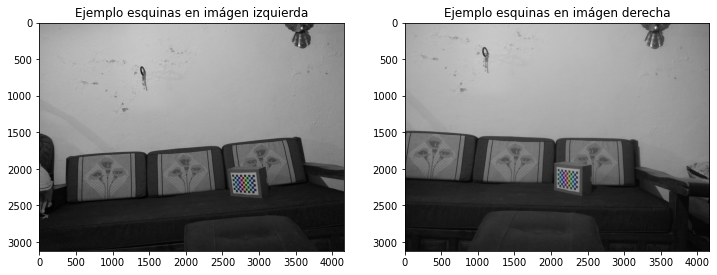

In [4]:

#Encontramos las esquinas en los patrones de ajedrez derecho e izquierdo
calibrator.detectCorners()

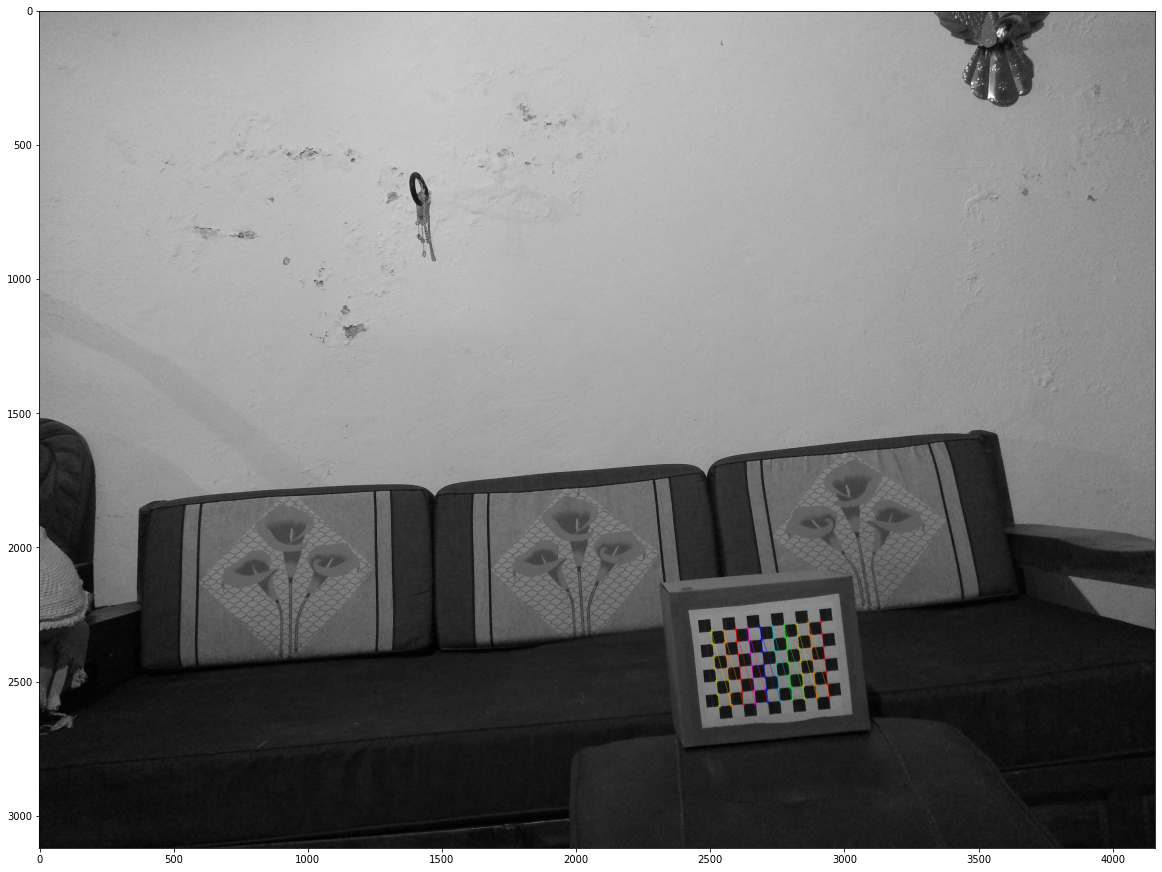

In [5]:
#Versión ampliada
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(calibrator.imagesWithCornersLeft[9], cv2.COLOR_BGR2RGB))

In [6]:
calibrator.calibrateCamera()

print("La matriz intrinseca de la cámara izquierda es "+str(calibrator.cameraMatrixLeft))

print("La matriz intrinseca de la cámara derecha es "+str(calibrator.cameraMatrixRight))

print("Los errores de reproyección stereo son "+str(calibrator.errors))

La matriz intrinseca de la cámara izquierda es [[3.07101276e+03 0.00000000e+00 2.02764386e+03]
 [0.00000000e+00 3.08973915e+03 1.54105818e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
La matriz intrinseca de la cámara derecha es [[3.10355537e+03 0.00000000e+00 1.95418406e+03]
 [0.00000000e+00 3.09654533e+03 1.55971809e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Los errores de reproyección stereo son [[1.30046994 1.31456263]
 [1.35524411 1.24061913]
 [0.75396239 0.34835451]
 [1.4312212  0.88000037]
 [1.92732623 2.19545181]
 [0.78122105 0.87072885]
 [0.98105555 1.1630808 ]
 [0.77909232 0.82578877]
 [1.39218474 0.96837333]
 [0.93536567 0.93922522]
 [1.24863344 1.50525331]
 [2.07374725 0.95876383]
 [1.55777192 1.4647963 ]]


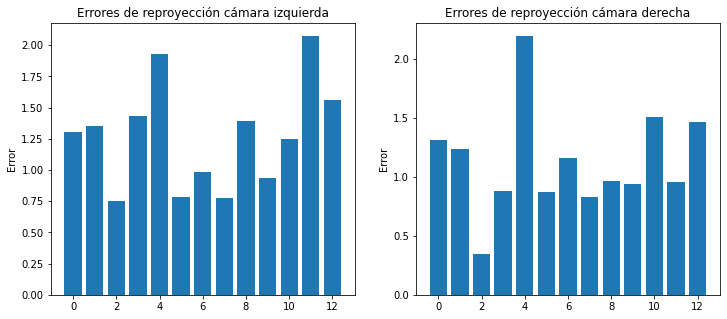

In [7]:
x = range(len(calibrator.errors))
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#La primera imagen con su snake resultante
ax[0].set_title("Errores de reproyección cámara izquierda")
ax[0].bar(x,calibrator.errors[:,0])
ax[0].set_ylabel("Error")
#La decima imagen con su snake resultante
ax[1].set_title("Errores de reproyección cámara derecha")
ax[1].bar(x,calibrator.errors[:,1])
ax[1].set_ylabel("Error")
plt.show()



<h2>2.-Obtención de una distancia usando disparidad</h2>

Brevemente recordemos que la profundidad a la que se encuentra un pixel (relativo al centro de la linea que une a ambas cámaras ) se calcula como:

\begin{equation}
Z = \frac{b\times f}{d}
\end{equation}

donde $b$ es la linea base, que calcularemos como la norma del vector de traslación entre las dos cámaras, $f$ sería la distancia focal, y $d$ es la disparidad. Cuando tengamos un mapa de profundidades para los objetos que conforman la escena entonces será facil por medio de substracción obtener la distancia entre ellos. 


In [93]:
class DepthCalculator:
    
    view1 = None
    view2 = None
    rectifiedView1 = None
    rectifiedView2 = None
    calibrator  = None
    width = None
    height = None
    
    #Recibe un objeto del tipo calibrator y las dos imágenes
    def __init__(self,view1,view2,calibrator):
        self.view1 = view1
        self.view2 = view2
        self.calibrator = calibrator
        #The width and height of images
        self.width = np.size(view1,1)
        self.height = np.size(view1,0)
        self.cameraLeft = self.calibrator.cameraMatrixLeft
        self.cameraRight = self.calibrator.cameraMatrixRight
        #Creamos el estado para el mapa de disparidad
        block = 7
        self.state = cv2.StereoSGBM_create(numDisparities = 32, blockSize = block)
        #self.state.setP1(8*block*block)
        #self.state.setP2(32*block*block)
        #self.state.setPreFilterSize(9)
        #self.state.setPreFilterCap(10)
        #self.state.setMinDisparity(0)
        #self.state.setTextureThreshold(5)
        #self.state.setUniquenessRatio(1)
        #self.state.setSpeckleWindowSize(70)
        #self.state.setSpeckleRange(1)
        #self.state.setFullDP(True)
        #self.state.setDisp12MaxDiff(10)
    

        
        
    def undistortImages(self):
        self.view1Undistorted = cv2.undistort(self.view1,self.cameraLeft,self.calibrator.distortCoeffsLeft)
        self.view2Undistorted = cv2.undistort(self.view2, self.cameraRight, self.calibrator.distortCoeffsRight)
        
        
        
        
    #Vamos a rectificar las camaras usando nuestra calibración
    def rectifyImages(self):
        #Hacemos rectificación estereoscópica
        rotation1, rotation2, pose1, pose2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(self.cameraLeft,self.calibrator.distortCoeffsLeft, self.cameraRight, self.calibrator.distortCoeffsRight, (self.width,self.height), self.calibrator.rotation, self.calibrator.translation,cv2.CALIB_ZERO_DISPARITY,alpha = 0)
        #Esta matriz será importante para obtener el mapa de profundidad
        self.Q = Q
        #Una vez hecho eso vamos a obtener como se ven nuestras imagenes desde estas perspectivas rectificadas
        mapxLeft, mapyLeft = cv2.initUndistortRectifyMap(self.cameraLeft, self.calibrator.distortCoeffsLeft, rotation1, pose1,(self.width,self.height),cv2.CV_16SC2)
        mapxRight, mapyRight = cv2.initUndistortRectifyMap(self.cameraRight,self.calibrator.distortCoeffsRight, rotation2, pose2, (self.width,self.height),cv2.CV_16SC2)
        
        self.rectifiedView1 = cv2.remap(self.view1Undistorted, mapxLeft, mapyLeft, cv2.INTER_LINEAR)
        self.rectifiedView2 = cv2.remap(self.view2Undistorted, mapxRight, mapyRight, cv2.INTER_LINEAR)
    
    #Ya que tenemos nuestras imágenes rectificadas 
    
    
    #Una vaz que hemos rectificado podemos obtener un mapa de disparidad 
    def computeDisparityMap(self):
        disparity = self.state.compute(self.rectifiedView1,self.rectifiedView2)
        #disparity = cv2.FindStereoCorrespondenceBM(self.rectifiedView1,self.rectifiedView2,self.state)
        self.disparityMap = disparity
    
    def computeDepthMap(self):
        f = self.Q[2,3]
        b = -1/self.Q[3,2]
        print(f)
        print(b)
        n = np.size(self.disparityMap,0)
        m = np.size(self.disparityMap,1)
        self.depthMap = np.zeros((n,m))
        
        for i in range(0,n):
            for j in range(0,m):
                if(self.disparityMap[i,j]  != 0):
                    self.depthMap[i,j] = (b*f)/self.disparityMap[i,j]
    def obtainDepthDifference(self,x1,y1,x2,y2):
        return np.abs(self.depthMap[y1,x1]-self.depthMap[y2,x2])
        
        

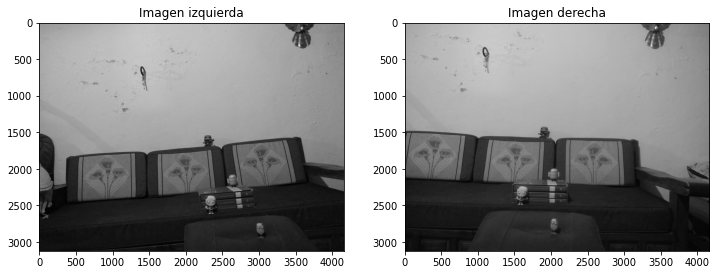

In [94]:
#Abrimos las dos imagenes 
imageLeft = cv2.imread('pair_2/left_1.JPG')
imageRight = cv2.imread('pair_2/right_1.JPG')


imageLeft = cv2.cvtColor(imageLeft,cv2.COLOR_BGR2GRAY)
imageRight = cv2.cvtColor(imageRight,cv2.COLOR_BGR2GRAY)
#Vamos a desplegarlas solo para que se vea despues la diferencia en la rectificación


fig, ax = plt.subplots(1,2,figsize=(12, 5))
#La primera imagen con su snake resultante
ax[0].imshow(imageLeft,cmap = "gray")
ax[0].set_title("Imagen izquierda")
#La decima imagen con su snake resultante
ax[1].imshow(imageRight,cmap = "gray")
ax[1].set_title("Imagen derecha")
plt.show()



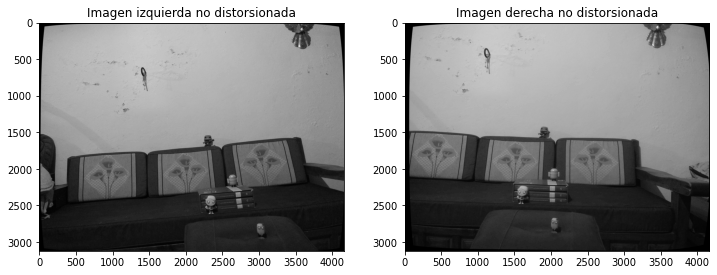

In [95]:
depthCalculator = DepthCalculator(imageLeft,imageRight,calibrator)
depthCalculator.undistortImages()
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#La primera imagen con su snake resultante
ax[0].imshow(depthCalculator.view1Undistorted,cmap = "gray")
ax[0].set_title("Imagen izquierda no distorsionada")
#La decima imagen con su snake resultante
ax[1].imshow(depthCalculator.view2Undistorted,cmap = "gray")
ax[1].set_title("Imagen derecha no distorsionada")
plt.show()


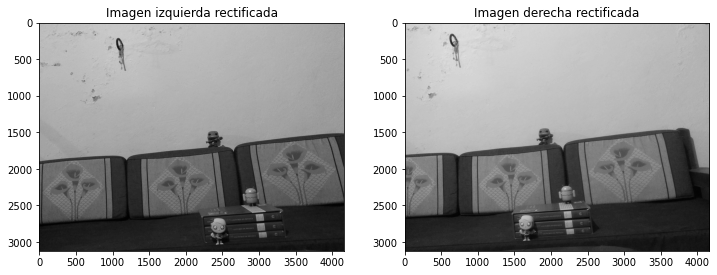

In [96]:
#Ya que tenemos las imagenes vamos a inciializar un objeto de clase DepthCalculator con ellas. 

depthCalculator.rectifyImages()
fig, ax = plt.subplots(1,2,figsize=(12, 5))
#La primera imagen con su snake resultante
ax[0].imshow(depthCalculator.rectifiedView1,cmap = "gray")
ax[0].set_title("Imagen izquierda rectificada")
#La decima imagen con su snake resultante
ax[1].imshow(depthCalculator.rectifiedView2,cmap = "gray")
ax[1].set_title("Imagen derecha rectificada")
plt.show()


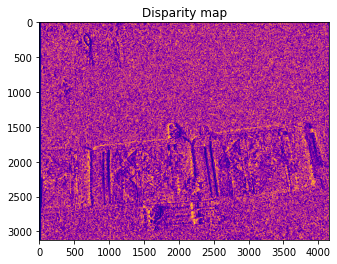

In [97]:
#EL mapa de disparidad
depthCalculator.computeDisparityMap()

plt.figure()
plt.title("Disparity map")
plt.imshow(depthCalculator.disparityMap,cmap = "plasma")

In [100]:
depthCalculator.computeDepthMap()

4408.1326000982435
-242.75803229242248


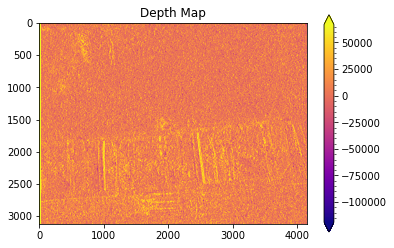

In [101]:
fig = plt.figure()
plt.title("Depth Map")
im = plt.imshow(depthCalculator.depthMap, cmap = 'plasma')
cbar = fig.colorbar(im, extend='both')
cbar.minorticks_on()
plt.show()

In [102]:
np.max(depthCalculator.depthMap)

66881.84975524561

-2311.251827395097
66881.84975524561
69193.10158264071


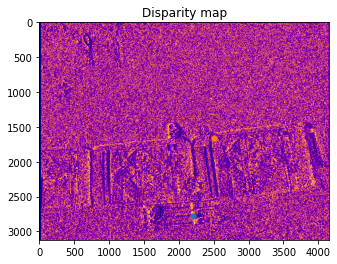

In [155]:
pt1N = 2200
pt1M = 2780
pt2N = 2500
pt2M = 1652
print(depthCalculator.depthMap[pt1M,pt1N])
print(depthCalculator.depthMap[pt2M,pt2N])
print(depthCalculator.obtainDepthDifference(pt1N,pt1M,pt2N,pt2M))

plt.figure()
plt.title("Disparity map")
plt.imshow(depthCalculator.disparityMap,cmap = "plasma")
plt.plot(pt1N,pt1M,'o',markersize = 5)
plt.plot(pt2N,pt2M,'o',markersize = 5)